# CIL Road Segmentation Project 2020 
Group Roadtripper


*   Tommaso
*   Yihang
*   Zhenhan
*   Jonas


---



# Establishment of the working environment
First, we have to import some needed python helper libraries like numpy. Then we need to import Keras, which is built on top of Tensorflow.

In [ ]:
# Import Colab libraries
from google.colab import drive
import os

# Import Numpy and Mathplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import scikit-learn
from sklearn.model_selection import train_test_split

# Import Keras with backend Tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import *
from tensorflow.python.keras import Sequential
import keras
from keras.utils import np_utils

Using TensorFlow backend.


In [ ]:
keras.__version__

'2.3.1'

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
# Test, if Google Colab runs in GPU mode
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Mount Google Drive to virtual machine
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Change directory to working folder
%cd '/content/drive/My Drive/CIL2020_Project/model1_classification'

/content/drive/My Drive/CIL2020_Project/model1_classification


# Image Import
First, we load the training images and their coresponding ground truth in the numpy array x_train and y_train. Then we split the available data into training and validation data.

In [ ]:
# Load images

# Root directory for training samples
root_dir = "training/"

# Folder with satelite images
x_directory = root_dir + "images/"

# Folder with groundtruth images
y_directory = root_dir + "groundtruth/"

# List all images
files = os.listdir(x_directory)

# Get image length
n = len(files)

print("Loading " + str(n) + " satelite images into x_train")
x_train = np.asarray([mpimg.imread(x_directory + files[i]) for i in range(n)])


print("Loading " + str(n) + " ground-truth images into y_train")
y_train = np.asarray([mpimg.imread(y_directory + files[i]) for i in range(n)])

Loading 100 satelite images into x_train
Loading 100 ground-truth images into y_train


In [ ]:
# Print the shape of both arrays
print("x_train shape: " + str(x_train.shape))
print("y_train shape: " + str(y_train.shape))

x_train shape: (100, 456, 456, 3)
y_train shape: (100, 456, 456, 3)


In [ ]:
# Split training and validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("---------------------------")
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (90, 456, 456, 3)
y_train:  (90, 456, 456, 3)
---------------------------
x_val:  (10, 456, 456, 3)
y_val:  (10, 456, 456, 3)


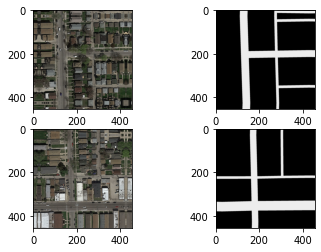

In [ ]:
# Plot two images and the corresponding ground truth images
index = 0

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[index])
axarr[0,1].imshow(y_train[index])
axarr[1,0].imshow(x_train[index+1])
axarr[1,1].imshow(y_train[index+1])

# Preprocessing: Image Patch Generator
We have to preprocess the images in order to feed them into the neural network. We do this by creating a python generator which produces training batches of patches, which have a size of 72x72px. This patches are extracted out of the training data images. The center 16x16px is being labeled either 0/1 using the groundtruth image. We augment the patches by rotating and flipping them randomly to have more training samples.

The same is done for the validation set.

In [ ]:
# Define the python generator, which outputs augmented image batches for training
def training_generator():
            batch_size=125
            window_size=72
            patch_size=16
            nb_classes = 2

            while 1:
                # Generate one minibatch
                X_batch = np.empty((batch_size, window_size, window_size, 3))
                Y_batch = np.empty((batch_size, 2))
                for i in range(batch_size):
                    # Select a random image
                    idx = np.random.choice(x_train.shape[0])
                    shape = x_train[idx].shape
                    
                    # Sample a random window from the image
                    center = np.random.randint(window_size//2, shape[0] - window_size//2, 2)
                    sub_image = x_train[idx][center[0]-window_size//2:center[0]+window_size//2,
                                       center[1]-window_size//2:center[1]+window_size//2]
                    gt_sub_image = y_train[idx][center[0]-patch_size//2:center[0]+patch_size//2,
                                          center[1]-patch_size//2:center[1]+patch_size//2]
                    
                    # The label does not depend on the image rotation/flip (provided that the rotation is in steps of 90°)
                    threshold = 0.25
                    label = (np.array([np.mean(gt_sub_image)]) > threshold) * 1
                    
                    # Image augmentation
                    # Random flip
                    if np.random.choice(2) == 0:
                        # Flip vertically
                        sub_image = np.flipud(sub_image)
                    if np.random.choice(2) == 0:
                        # Flip horizontally
                        sub_image = np.fliplr(sub_image)
                    
                    # Random rotation in steps of 90°
                    num_rot = np.random.choice(4)
                    sub_image = np.rot90(sub_image, num_rot)

                    label = np_utils.to_categorical(label, nb_classes)
                    X_batch[i] = sub_image
                    Y_batch[i] = label
                
                    
                yield (X_batch, Y_batch)


In [ ]:
# Create validation set

def validation_generator():
            batch_size=8000
            window_size=72
            patch_size=16
            nb_classes = 2

            while 1:
                # Generate one minibatch
                X_batch = np.empty((batch_size, window_size, window_size, 3))
                Y_batch = np.empty((batch_size, 2))
                for i in range(batch_size):
                    # Select a random image
                    idx = np.random.choice(x_val.shape[0])
                    shape = x_val[idx].shape
                    
                    # Sample a random window from the image
                    center = np.random.randint(window_size//2, shape[0] - window_size//2, 2)
                    sub_image = x_val[idx][center[0]-window_size//2:center[0]+window_size//2,
                                       center[1]-window_size//2:center[1]+window_size//2]
                    gt_sub_image = y_val[idx][center[0]-patch_size//2:center[0]+patch_size//2,
                                          center[1]-patch_size//2:center[1]+patch_size//2]
                    
                    # The label does not depend on the image rotation/flip (provided that the rotation is in steps of 90°)
                    threshold = 0.25
                    label = (np.array([np.mean(gt_sub_image)]) > threshold) * 1
                    
                    # Image augmentation
                    # Random flip
                    if np.random.choice(2) == 0:
                        # Flip vertically
                        sub_image = np.flipud(sub_image)
                    if np.random.choice(2) == 0:
                        # Flip horizontally
                        sub_image = np.fliplr(sub_image)
                    
                    # Random rotation in steps of 90°
                    num_rot = np.random.choice(4)
                    sub_image = np.rot90(sub_image, num_rot)

                    # Sth TBD further: brightness, zoom level

                    label = np_utils.to_categorical(label, nb_classes)
                    X_batch[i] = sub_image
                    Y_batch[i] = label
                
                    
                yield (X_batch, Y_batch)


[1. 0.]
(125, 72, 72, 3)
(125, 2)


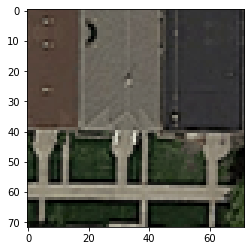

In [ ]:
# Test training data generator
x_train_batch, y_train_batch = next(training_generator())

# Plot a test image
plt.imshow(x_train_batch[0])

# And the corresponding one hot enconding of y
print(y_train_batch[0])

# Shape of x_train_batch
print(x_train_batch.shape)

# Shape of y_train_batch
print(y_train_batch.shape)

In [ ]:
# Create validation set
x_val_batch, y_val_batch = next(validation_generator())

# Shape of x_train_batch
print(x_val_batch.shape)

# Shape of y_train_batch
print(y_val_batch.shape)

(8000, 72, 72, 3)
(8000, 2)


# Building the Convolutional Neural Network based on Xception
The following CNN architecture is defined with the base model from Xception. 
We first apply the convolutonal layers from the Xception model that were 
trained on ImageNet and train our dense layers. Furthermore, we can fine 
tune the parameters of top layers if that helps to improve the validation 
accuracy.

In [ ]:
# Define the CNN model
BATCH_SHAPE = (72, 72, 3)

# Create the base model from the pre-trained model Xception
base_model = tf.keras.applications.Xception(
    include_top = False,
    weights = 'imagenet',
    input_shape = BATCH_SHAPE
)

# Freeze the base model prior to training the classifier
base_model.trainable = False

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
# Print the architecture of base model
base_model.summary()

In [ ]:
# Get the output of the last layer of base model
last_output = base_model.get_layer('block14_sepconv2_act').output

# Add dense layers for classification
x = Flatten(name="block15_flatten")(last_output)
x = Dense(512, kernel_regularizer=keras.regularizers.l2(1e-6), name="block15_dense")(x)
x = LeakyReLU(alpha = 0.1, name="block15_act")(x)
x = Dropout(0.5, name="block15_dropout")(x)
# Add a final softmax layer for classification
x = Dense(2, activation="softmax", kernel_regularizer=keras.regularizers.l2(1e-6), name="block16_dense")(x)

In [ ]:
from tensorflow.keras import Model
# Define the model
model = Model(base_model.input, x)
# Print the model architecture 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72, 72, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

# Training the model
First we have to compile the model and define the callback functions, which are being called each epoch. After that, it is finally time for training. After the training is finished the weights are saved in the current working directory for later usage.

In [ ]:
# Compile the model
base_learning_rate = 0.0001
model.compile(Adam(lr=base_learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Define callback functions (reduce the learning rate if accuracy doesn't change that much and early stopping, when accuracy doesn't change anymore.)
reduce_learningrate = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.0002, patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("weights/weights.{epoch:02d}-{accuracy:.4f}.h5", monitor='accuracy', save_weights_only=True, period=5)
initial_epochs = 30

In [ ]:
# Train model with validation data
history = model.fit(training_generator(), validation_data=(x_val_batch, y_val_batch), steps_per_epoch=1500, epochs=initial_epochs, callbacks=[reduce_learningrate, early_stopping, checkpoint])
model.save("model_Xception.h5", overwrite=True)

Epoch 1/30
1500/1500 [==============================] - 75s 50ms/step - loss: 0.4300 - accuracy: 0.8088 - val_loss: 0.3444 - val_accuracy: 0.8501 - lr: 1.0000e-04
Epoch 2/30
1500/1500 [==============================] - 74s 49ms/step - loss: 0.3866 - accuracy: 0.8283 - val_loss: 0.3317 - val_accuracy: 0.8551 - lr: 1.0000e-04
Epoch 3/30
1500/1500 [==============================] - 75s 50ms/step - loss: 0.3689 - accuracy: 0.8356 - val_loss: 0.3230 - val_accuracy: 0.8604 - lr: 1.0000e-04
Epoch 4/30
1500/1500 [==============================] - 74s 49ms/step - loss: 0.3544 - accuracy: 0.8419 - val_loss: 0.3229 - val_accuracy: 0.8572 - lr: 1.0000e-04
Epoch 5/30
1500/1500 [==============================] - 74s 50ms/step - loss: 0.3469 - accuracy: 0.8462 - val_loss: 0.3178 - val_accuracy: 0.8612 - lr: 1.0000e-04
Epoch 6/30
1500/1500 [==============================] - 74s 50ms/step - loss: 0.3368 - accuracy: 0.8499 - val_loss: 0.3229 - val_accuracy: 0.8579 - lr: 1.0000e-04
Epoch 7/30
1500/1500 [

# Fine tuning
Fine tune the parameters of top layers of the base model.

In [ ]:
# Set the layers of base model as trainable
base_model.trainable = True

# Print the number of layers in base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [ ]:
print(len(model.layers))

137


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 90

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# load the model from the latest checkpoint if the training was interrupted
# Skip this block if the training was carried for the first time
model.load_weights("weights/weights.54-0.9566.h5")

In [ ]:
# Compile the model with a lower learning rate
model.compile(Adam(lr=base_learning_rate/10), loss="categorical_crossentropy", metrics=["accuracy"])

# Keep training the model
fine_tune_epochs = 90
total_epochs = initial_epochs + fine_tune_epochs

# Set a new early stopping condition 
#early_stopping_fine = EarlyStopping(monitor='val_accuracy', min_delta=0.0002, patience=10, verbose=1, mode='auto')

# Train model with validation data
history_fine = model.fit(training_generator(), 
            validation_data=(x_val_batch, y_val_batch), 
            steps_per_epoch=1500, 
            epochs=total_epochs, 
            #initial_epoch=history.epoch[-1], 
            initial_epoch=54,
            callbacks=[reduce_learningrate, early_stopping, checkpoint])

# Save the model
model.save("model_Xception_tuned.h5", overwrite=True)

Epoch 55/120
1500/1500 [==============================] - 115s 76ms/step - loss: 0.1082 - accuracy: 0.9566 - val_loss: 0.2427 - val_accuracy: 0.9115 - lr: 1.0000e-05
Epoch 56/120
1500/1500 [==============================] - 114s 76ms/step - loss: 0.1055 - accuracy: 0.9587 - val_loss: 0.2306 - val_accuracy: 0.9154 - lr: 1.0000e-05
Epoch 57/120
1500/1500 [==============================] - 114s 76ms/step - loss: 0.1052 - accuracy: 0.9585 - val_loss: 0.2333 - val_accuracy: 0.9169 - lr: 1.0000e-05
Epoch 58/120
1500/1500 [==============================] - 114s 76ms/step - loss: 0.1005 - accuracy: 0.9601 - val_loss: 0.2328 - val_accuracy: 0.9169 - lr: 1.0000e-05
Epoch 59/120
1500/1500 [==============================] - 115s 77ms/step - loss: 0.0991 - accuracy: 0.9611 - val_loss: 0.2331 - val_accuracy: 0.9215 - lr: 1.0000e-05
Epoch 60/120
1500/1500 [==============================] - 114s 76ms/step - loss: 0.1002 - accuracy: 0.9598 - val_loss: 0.2350 - val_accuracy: 0.9180 - lr: 1.0000e-05
Epoc

# Training Visualization
By looking at the model accuracy and loss plot of training and validation data, one can see, if the model is overfitting or underfitting and when it is a good time to stop training. Besides, the improvements by fine tunning parameters can be observed.

In [ ]:
# Plot training & validation accuracy values before fine tuning
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Plot the training and validation accuracy after fine tunning
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

# Plot the figure
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# How to prevent Google Colab from disconnecting?
Set a javascript interval to click on the connect button every 60 seconds. Open developer-settings (in your web-browser) with Ctrl+Shift+I then click on console tab and type this on the console prompt.


```
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```



In [ ]:
model1 = tf.keras.models.load_model("model.h5")
model2 = tf.keras.models.load_model("model_Xception_tuned.h5")

In [ ]:
loss, acc = model1.evaluate(x_val_batch, y_val_batch, verbose=2)
print("Model1, accuracy: {:5.2f}%".format(100*acc))

loss, acc = model2.evaluate(x_val_batch, y_val_batch, verbose=2)
print("Model2, accuracy: {:5.2f}%".format(100*acc))

250/250 - 2s - loss: 0.1627 - accuracy: 0.9563
Model1, accuracy: 95.63%
250/250 - 4s - loss: 0.2261 - accuracy: 0.9247
Model2, accuracy: 92.47%


In [ ]:
x_test = np.load("testing/x_test.npy")

In [ ]:
y_test = model1.predict(x_test)

In [ ]:
y_test = np.argmax(y_test, axis=1)

In [ ]:
import pandas as pd
pd.Series(y_test).to_csv("y_test_cla_trans_02.csv", header=False, index=False)